In [89]:
#!pip install matplotlib

In [96]:
import pandas as pd
import matplotlib as plt
df = pd.read_excel('data/data_unpacked.xlsx')

# 2. Data Understanding

## 2.2 Describe data

### Get some samples

In [97]:
df.sample(5)

,url,title,creator,created,artist,category,dimension
7888,https://lh3.googleusercontent.com/ci/ACqFvF313...,View of the Bosphorus as seen from Tarabya un...,Clara Barthold (Mayer),Late 18th century,NaN,TEAL,"46,5 x 68 cm."
573,https://lh3.googleusercontent.com/IxOsF69Ax8qp...,William Henry Harrison,NaN,1835,James Reid Lambdin,BLACK,w635 x h762 mm (without frame)
4201,https://lh3.googleusercontent.com/ci/ACqFvF19F...,Caves of Manacor,William Degouve de Nuncques,1901,NaN,GREEN,48.5 x 60.5 cm
6356,https://lh3.googleusercontent.com/ci/ACqFvF34K...,Fuga,Pérez Celis,1986,NaN,RED,24 x 30 in
3286,https://lh3.googleusercontent.com/ci/ACqFvF3j9...,Shylock and Jessica from the 'Merchant of Ven...,"Gilbert Stuart Newton, 1794–1835, British",1830,NaN,BROWN,35 x 29 1/2 inches (88.9 x 74.9 cm)\nFrame 45...


### Check shape and columns

In [98]:
print('shape', df.shape,'\n')
print('columns', df.columns.to_list(),'\n')

shape (10282, 7) 

columns ['url', 'title', 'creator', 'created', 'artist', 'category', 'dimension'] 



## 2.3 Explore data 

BLACK     1215
BLUE      1215
GREEN     1215
TEAL      1215
BROWN     1214
WHITE     1124
RED       1053
YELLOW    1013
ORANGE     811
PURPLE     121
PINK        86
Name: category, dtype: int64


<AxesSubplot:>

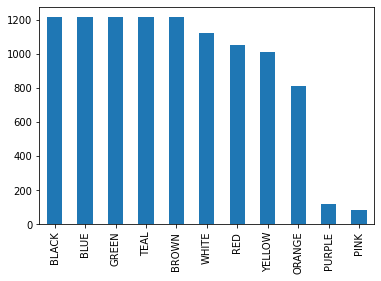

In [99]:
print(df['category'].value_counts())
df['category'].value_counts().plot(kind='bar')

### 2.4 Verify data quality

In [77]:
print('Missing Values')
print(df.isnull().sum(),'\n')

Missing Values
url             0
title          10
creator      1369
created      2217
artist       9805
category        0
dimension    1849
dtype: int64 



### Check info

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10292 entries, 0 to 10291
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        10292 non-null  object
 1   title      10282 non-null  object
 2   creator    8923 non-null   object
 3   created    8075 non-null   object
 4   artist     487 non-null    object
 5   category   10292 non-null  object
 6   dimension  8443 non-null   object
dtypes: object(7)
memory usage: 563.0+ KB


# Clean Artist and Creator fields

In [64]:
def join_creator_artist(row):
    if(not pd.isna(row['creator'])):
        return row['creator']
    if(not pd.isna(row['artist'])):
        return row['artist']
    return None

df2 = df.iloc[0:10]
df2['new']=df.apply(join_creator_artist, axis=1)
df2.head()

----------


C:\Users\user\AppData\Local\Temp\ipykernel_24624\1966221852.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['new']=df.apply(join_creator_artist, axis=1)


,url,title,creator,created,artist,category,dimension,new
0,https://lh3.googleusercontent.com/ci/ACqFvF1fa...,Girl with a Pearl Earring,Johannes Vermeer,c. 1665 (digitized by Madpixel),artist,BLACK,44.5 x 38.1 cm,Johannes Vermeer
1,https://lh3.googleusercontent.com/IN4tL8PgTXxm...,American Gothic,"Grant Wood (American, 1891-1942)",1930,"Grant Wood (American, 1891-1942)",BLACK,78 × 65.3 cm (30 3/4 × 25 3/4 in.),"Grant Wood (American, 1891-1942)"
2,https://lh3.googleusercontent.com/b6TOe8s5BtvR...,Luncheon on the Grass,NaN,1863,NaN,BLACK,208 x 264.5 cm,None
3,https://lh3.googleusercontent.com/ci/ACqFvF0Lo...,Lady with an Ermine,Leonardo da Vinci,NaN,NaN,BLACK,NaN,Leonardo da Vinci
4,https://lh3.googleusercontent.com/LRWEui8Dl47I...,John Quincy Adams,NaN,1858,George P.A. Healy,BLACK,w1193.8 x h1574.8 mm (without frame),George P.A. Healy


In [72]:
df3 = df2.copy()
df3['dimension'] = df['dimension'].str.replace(r'(-|x|\d\/\d|\(\D+\))', '', regex=True)
df3[~pd.isna(df3['dimension'])]

,url,title,creator,created,artist,category,dimension,new
0,https://lh3.googleusercontent.com/ci/ACqFvF1fa...,Girl with a Pearl Earring,Johannes Vermeer,c. 1665 (digitized by Madpixel),artist,BLACK,44.5 38.1 cm,Johannes Vermeer
1,https://lh3.googleusercontent.com/IN4tL8PgTXxm...,American Gothic,"Grant Wood (American, 1891-1942)",1930,"Grant Wood (American, 1891-1942)",BLACK,78 × 65.3 cm (30 × 25 in.),"Grant Wood (American, 1891-1942)"
2,https://lh3.googleusercontent.com/b6TOe8s5BtvR...,Luncheon on the Grass,NaN,1863,NaN,BLACK,208 264.5 cm,None
4,https://lh3.googleusercontent.com/LRWEui8Dl47I...,John Quincy Adams,NaN,1858,George P.A. Healy,BLACK,w1193.8 h1574.8 mm,George P.A. Healy
6,https://lh3.googleusercontent.com/3agAzqx7Z4c_...,The Night Watch,Rembrandt Harmensz van Rijn,1642,NaN,BLACK,w4370 h3630 mm,Rembrandt Harmensz van Rijn
7,https://lh3.googleusercontent.com/V1EAvZPBHNHm...,Nighthawks,"Edward Hopper (American, 1882-1967)",1942,"Edward Hopper (American, 1882-1967)",BLACK,84.1 × 152.4 cm (33 × 60 in.),"Edward Hopper (American, 1882-1967)"
8,https://lh3.googleusercontent.com/ci/ACqFvF1vn...,Portrait of the Artist's Mother,NaN,1871,NaN,BLACK,w1620 h1440 mm,None
9,https://lh3.googleusercontent.com/nLaHl2UJRzrf...,Starry Night,NaN,1888,NaN,BLACK,w920 h720 mm,None


In [28]:
import pandas as pd


a = ['1','2','3',None,'5']
b = ['1','2',None,'4','5']
data = {'a':a, 'b':b}

df = pd.DataFrame(data)
df2=df.apply(lambda row:row['a'] or row['b'], axis=1)

print(df2)

0    1
1    2
2    3
3    4
4    5
dtype: object
